In [22]:
# np.random.seed(666)
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
from alive_progress import alive_bar
from project_package.generate_pop import SymPop
from project_package.generate_pop import generate_initial_pop_unlinked
from project_package.run_model import update_pop, update_pop_with_tracers,update_pop2_with_tracers
import tracemalloc
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Testing the effect of population size on the update time and memory requirement

the update_pop pseudocode:

1. Generate population attributes from graph. Fitnesses and abundances as dict, alleles normalised relative fitnesses (weights per allele) as list
2. Generate new population abundances dictionary by multinomial sampling with weights as probabilities
3. Randomly choose a certain number of individuals to mutate (according to mutation rate)
4. If mutation occured:
   4.1. Decide which individuals/alleles mutated according to their relative abundance
   4.2. Remove these individuals from the new_pop (dict and graph)
   4.3. Attribute fitness to new alleles according to fitness of the parents + random bias
   4.4. Update new_pop dict and graph to add new alleles


## Rough tracers

In [176]:
df=pd.DataFrame([],columns=['trial','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst'])
time_df=pd.DataFrame([],columns=['trial','gen','time_chunk','value'])

# mutation_rate=0.000000000001 # 10-12
mutation_rate=0 

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[300000000,700000000] # allele_id:abundance
verbose=False

trials=10
runtime=200

POP=generate_initial_pop_unlinked(fitnesses,abundances)

with alive_bar(trials*runtime,force_tty=True) as bar:
    
    for trial in range(trials): # number of trials
        print(trial)
        G=POP.copy()
        t=0
        
    
        while True:
            t+=1
            
            tracemalloc.start()
            start_time = time.time()
    
            G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop_with_tracers(G,mutation_rate,growth_factor=growth_factor)
            # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
            
            tot_exec_time=time.time() - start_time

            mem_needed=sum(tracemalloc.get_traced_memory())

            time_df=pd.concat([time_df,
                   pd.DataFrame({'trial':[trial]*6,
                      'gen':[t]*6,
                      'time_chunk':['newG_copy','pop_attr', 'new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot'],
                      'value':[time_newG_copy, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut,tot_exec_time]
                     })])
            
            SP=SymPop(G_plus1)
            G=SP.G
            
            df.loc[-1] = [trial,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
            df.index = df.index + 1  # shifting index
            
            bar() 
            
            if t>runtime:
                break   
    
import seaborn as sns
plt.figure()
sns.lineplot(data=time_df[time_df.gen>150],x='gen',y='value',hue='time_chunk')

for var in ['mem_needed','pop_size','richness']:
    plt.figure()

    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var,
                 data=df[df.gen>150])

on 0: 0                                                                         


on 0: /var/folders/4k/fyxyxd_96gsc6cfglggb83tr0000gn/T/ipykernel_80078/4167908958.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
        time_df=pd.concat([time_df,


on 201: 1                                                                       
on 402: 2                                                                       
on 603: 3                                                                       
on 804: 4                                                                       
on 1005: 5                                                                      
on 1206: 6                                                                      
on 1407: 7                                                                      
on 1608: 8                                                                      
on 1809: 9                                                                      
|████████████████████████████████████████✗︎ (!) 2010/2000 [100%] in 20.5s (99.18/


trial   mem_needed  mutation_rate    gen      pop_size  richness  \
3    9.0  536510017.0   1.000000e-12  198.0  1.568488e+13      77.0   
2    9.0  536947873.0   1.000000e-12  199.0  1.646912e+13      75.0   
1    9.0  536229321.0   1.000000e-12  200.0  1.729258e+13      83.0   
0    9.0  536775337.0   1.000000e-12  201.0  1.815721e+13      93.0   

   mean_fitness       Fst  
3      0.939601  0.000105  
2      0.939249  0.000099  
1      0.939758  0.000094  
0      0.940049  0.000089

## Fine tracers

on 0: 0                                                                         


on 0: /var/folders/4k/fyxyxd_96gsc6cfglggb83tr0000gn/T/ipykernel_80078/888818167.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
        time_df=pd.concat([time_df,


on 201: 1                                                                       
on 402: 2                                                                       
on 603: 3                                                                       
on 804: 4                                                                        ▆▄▂ 624/2000 [31%] in 5s (~11s, 127.2
on 1005: 5                                                                      
on 1206: 6                                                                      
on 1407: 7                                                                      
on 1608: 8                                                                      
on 1809: 9                                                                      
|████████████████████████████████████████✗︎ (!) 2010/2000 [100%] in 16.0s (125.82


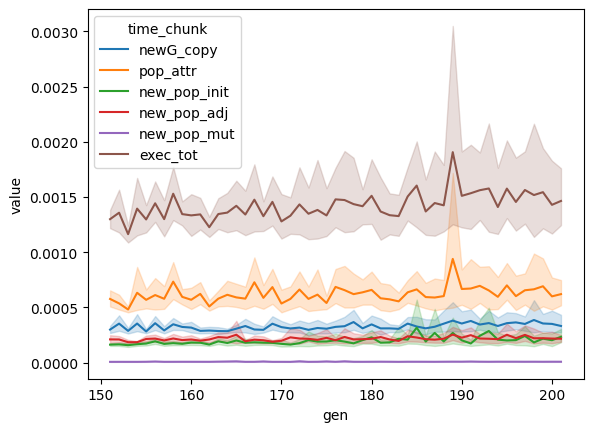

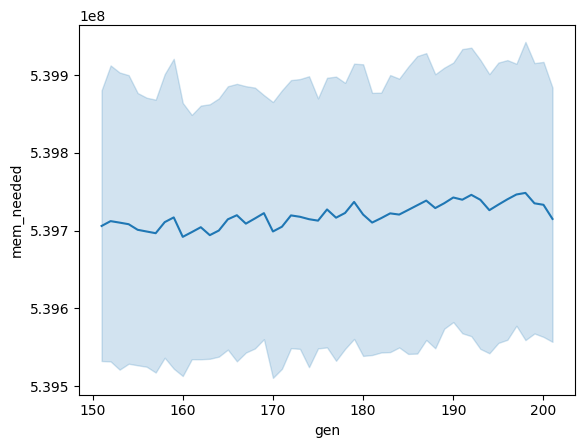

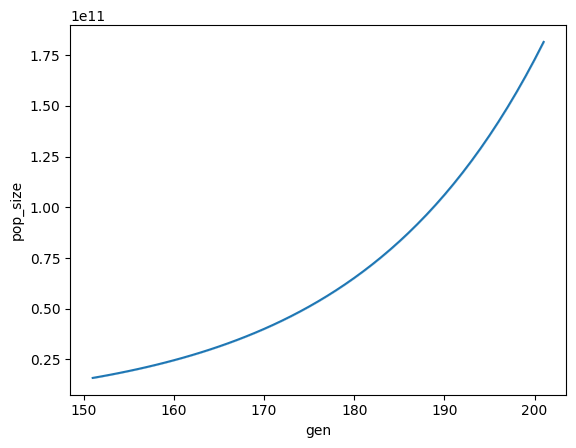

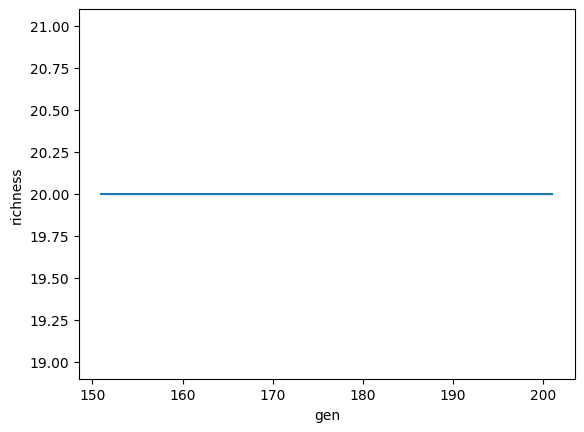

In [179]:
df=pd.DataFrame([],columns=['trial','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst'])
time_df=pd.DataFrame([],columns=['trial','gen','time_chunk','value'])

# mutation_rate=0.000000000001 # 10-12
mutation_rate=0 

growth_factor=1.05
fitnesses=[0.9]*20 # allele_id:fitness
abundances=[500000]*20 # allele_id:abundance
verbose=False

trials=10
runtime=200

POP=generate_initial_pop_unlinked(fitnesses,abundances)

with alive_bar(trials*runtime,force_tty=True) as bar:
    
    for trial in range(trials): # number of trials
        print(trial)
        G=POP.copy()
        t=0
        
    
        while True:
            t+=1
            
            tracemalloc.start()
            start_time = time.time()
    
            G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop_with_tracers(G,mutation_rate,growth_factor=growth_factor)
            # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
            
            tot_exec_time=time.time() - start_time

            mem_needed=sum(tracemalloc.get_traced_memory())

            time_df=pd.concat([time_df,
                   pd.DataFrame({'trial':[trial]*6,
                      'gen':[t]*6,
                      'time_chunk':['newG_copy','pop_attr', 'new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot'],
                      'value':[time_newG_copy, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut,tot_exec_time]
                     })])
            
            SP=SymPop(G_plus1)
            G=SP.G
            
            df.loc[-1] = [trial,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
            df.index = df.index + 1  # shifting index
            
            bar() 
            
            if t>runtime:
                break   
    
import seaborn as sns
plt.figure()
sns.lineplot(data=time_df[time_df.gen>150],x='gen',y='value',hue='time_chunk')

for var in ['mem_needed','pop_size','richness']:
    plt.figure()

    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var,
                 data=df[df.gen>150])

## V1 vs V2

on 0: /var/folders/4k/fyxyxd_96gsc6cfglggb83tr0000gn/T/ipykernel_17749/3990995630.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
        time_df=pd.concat([time_df,


|████████████████████████████████████████✗︎ (!) 3020/3000 [101%] in 17.4s (174.08


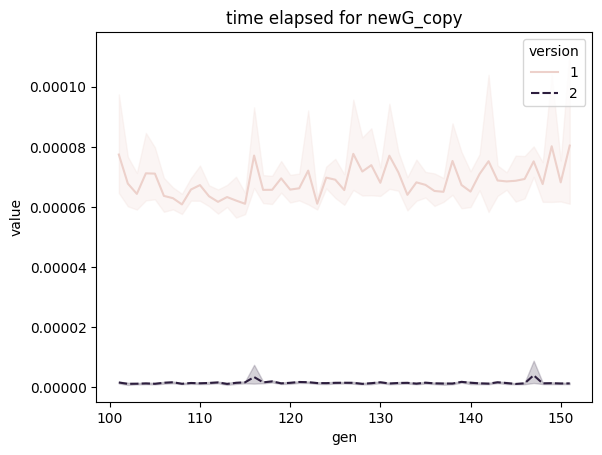

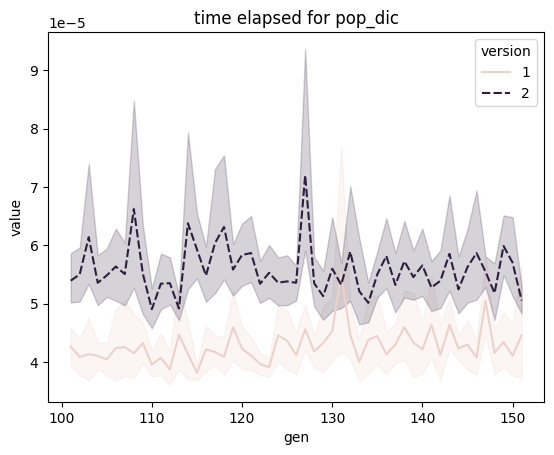

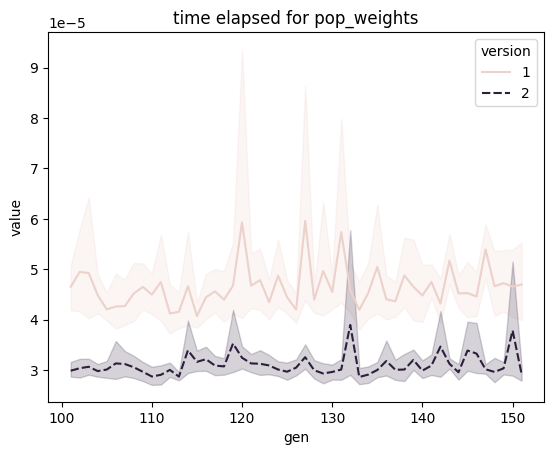

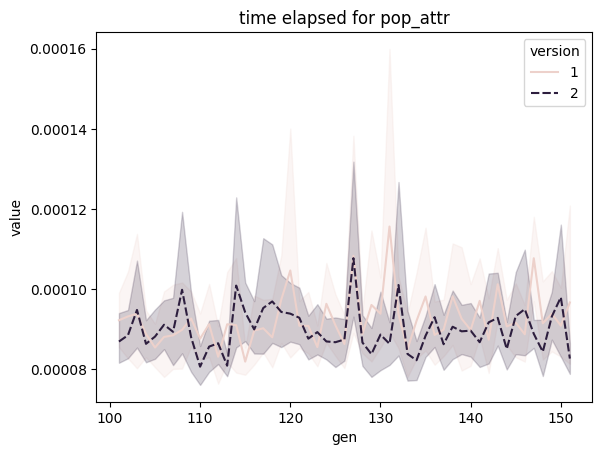

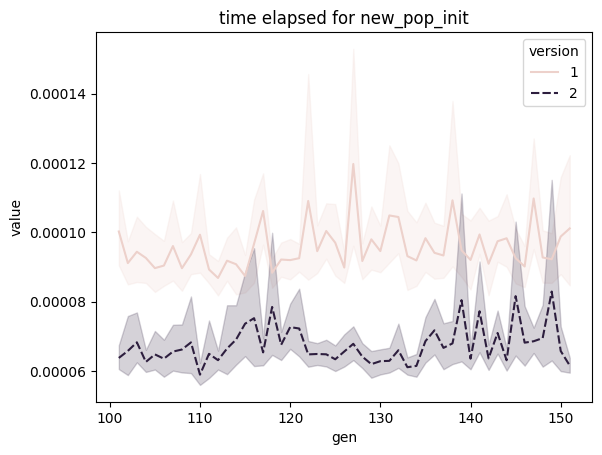

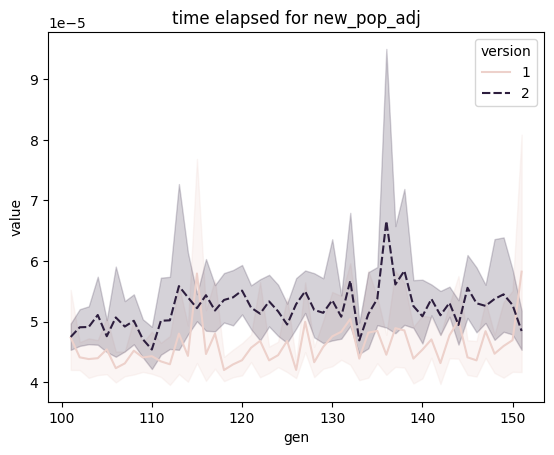

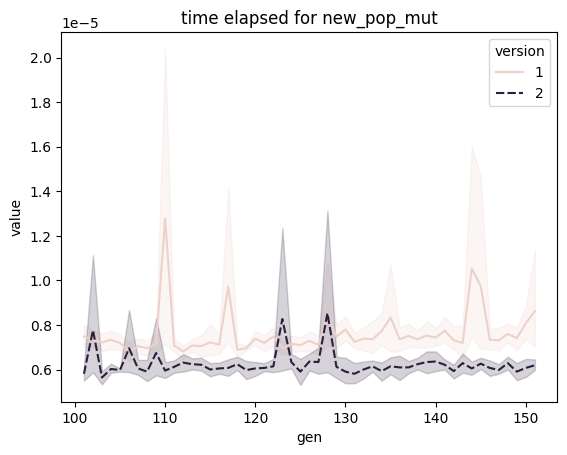

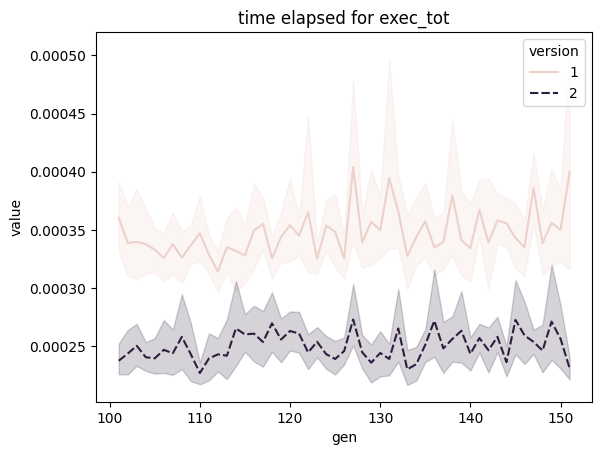

In [13]:
from project_package.run_model import update_pop2_with_tracers
from project_package.generate_pop import generate_random_initial_pop_unlinked

df=pd.DataFrame([],columns=['version','trial','gen','mem_needed','mutation_rate','pop_size','richness','mean_fitness','Fst'])
time_df=pd.DataFrame([],columns=['version','trial','gen','time_chunk','value'])



# mutation_rate=0.000000000001 # 10-12
mutation_rate=0 
# growth_factor=1.05
# fitnesses=[0.9]*20 # allele_id:fitness
# abundances=[500000]*20 # allele_id:abundance

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[300000000,700000000] # allele_id:abundance
n=sum(abundances)

trials=10
runtime=150
versions=[1,2]

with alive_bar(len(versions)*trials*runtime,force_tty=True) as bar:
    
    for trial in range(trials): # number of trials
        np.random.seed(trial+1)
        POP=generate_initial_pop_unlinked(fitnesses,abundances)

        
        for version in versions: # number of trials
            G=POP.copy()
            gen=0
    
            while True:
                gen+=1
                tracemalloc.start()
                start_time = time.time()
    
                if version==1:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                elif version==2:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop2_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                tot_exec_time=time.time() - start_time
    
                time_df=pd.concat([time_df,
                       pd.DataFrame({'version':[version]*8,
                                     'trial':[trial]*8,
                          'gen':[gen]*8,
                          'time_chunk':['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot'],
                          'value':[time_newG_copy, time_pop_dic,time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut,tot_exec_time]
                         })])
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                
                SP=SymPop(G_plus1)
                G=SP.G
                
                df.loc[-1] = [version,trial,gen,mem_needed,mutation_rate,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
        
                if gen>runtime:
                    break 
for var in ['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(data=time_df[(time_df.time_chunk==var) & (time_df.gen>100)],x='gen',y='value',hue='version',style='version').set(title='time elapsed for '+var)


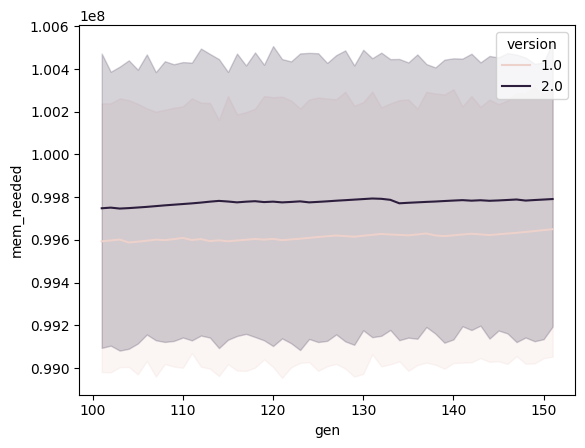

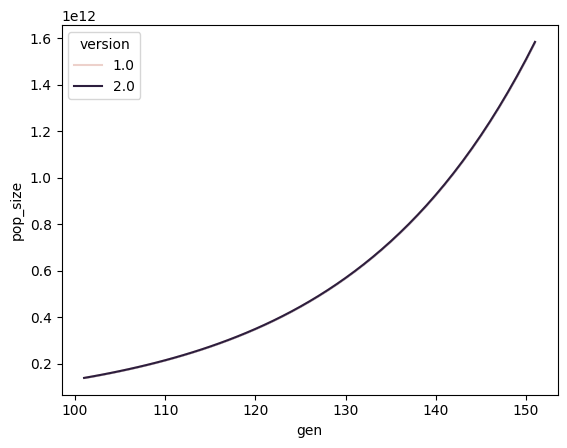

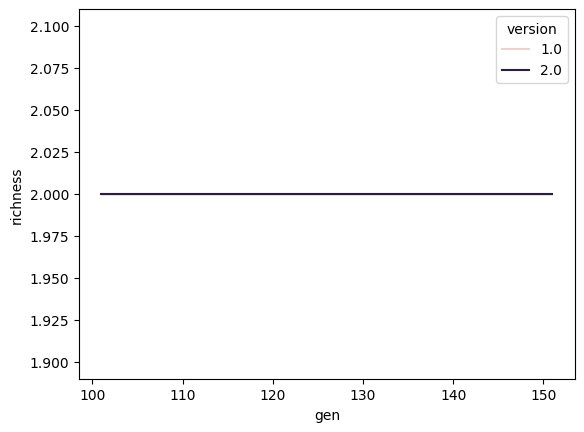

In [16]:
for var in ['mem_needed','pop_size','richness']:
    plt.figure()

    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var,hue='version',
                 data=df[df.gen>100])

# Testing the effect of strain diversity on time to update and memory needed

## Fine tracers

on 0: /var/folders/4k/fyxyxd_96gsc6cfglggb83tr0000gn/T/ipykernel_80078/3549528333.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
        time_df=pd.concat([time_df,


|████████████████████████████████████████| 480/480 [100%] in 4.1s (122.64/s)    


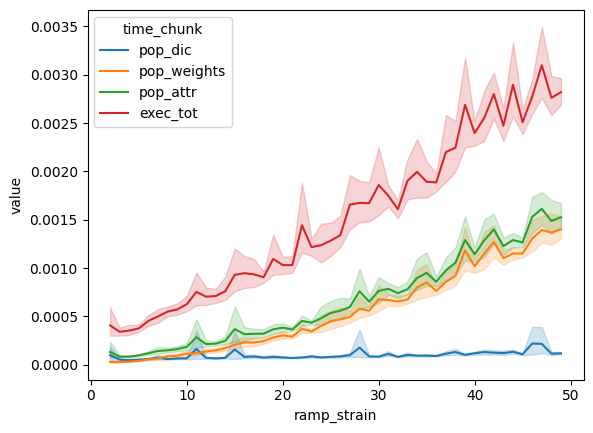

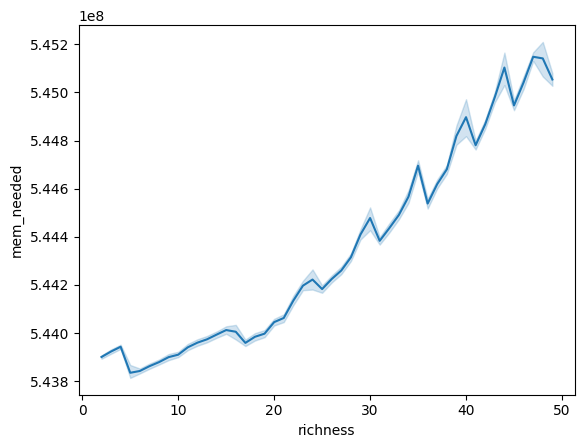

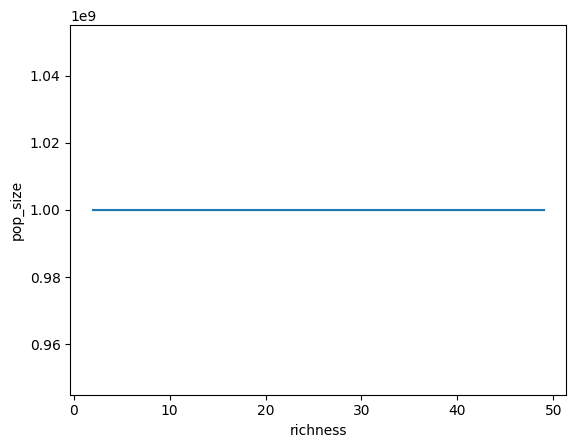

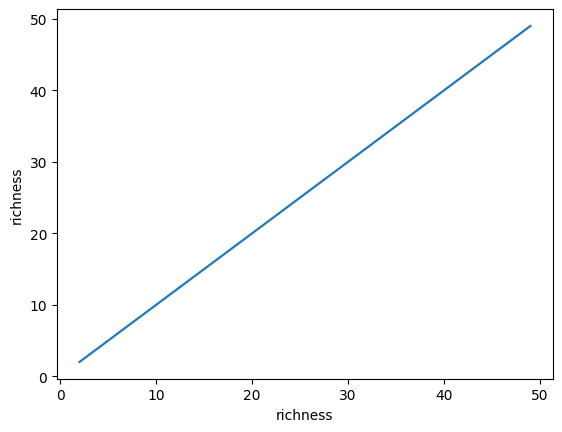

In [181]:

from project_package.generate_pop import generate_random_initial_pop_unlinked

df=pd.DataFrame([],columns=['trial','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst'])
time_df=pd.DataFrame([],columns=['trial','ramp_strain','time_chunk','value'])

mutation_rate=0 # 10-12
growth_factor=1
n=1000000000
verbose=False

trials=10
ramp_strain=range(2,50)

with alive_bar(trials*len(ramp_strain),force_tty=True) as bar:

    for strain_count in ramp_strain:

        POP=generate_random_initial_pop_unlinked(n=n,i=strain_count)
    
        for trial in range(trials): # number of trials
            G=POP.copy()
            tracemalloc.start()
            start_time = time.time()
    
            G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop_with_tracers(G,mutation_rate,growth_factor=growth_factor)
            # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
            tot_exec_time=time.time() - start_time

            time_df=pd.concat([time_df,
                   pd.DataFrame({'trial':[trial]*8,
                      'ramp_strain':[strain_count]*8,
                      'time_chunk':['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot'],
                      'value':[time_newG_copy, time_pop_dic,time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut,tot_exec_time]
                     })])
            
            mem_needed=sum(tracemalloc.get_traced_memory())
            
            SP=SymPop(G_plus1)
            
            df.loc[-1] = [trial,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
            df.index = df.index + 1  # shifting index
            
            bar() 
    
plt.figure()
sns.lineplot(data=time_df[(time_df.time_chunk.isin(['pop_dic','pop_weights','pop_attr',])) & (time_df.ramp_strain<50)],x='ramp_strain',y='value',hue='time_chunk')


## Compare update function v1 and v2

### testing code bits

In [66]:

############### v1 #################
timestart=time.time()

fitness_dic={node: attr['fitness'] for node,attr in G.nodes(data=True) if attr['abundance']>0}
population={node: attr['abundance'] for node,attr in G.nodes(data=True) if attr['abundance']>0}

time_pop_dic=time.time()-start_time-time_newG_copy #####

n=sum(list(population.values()))

alleles = list(population.keys())
abs_weights=[population[x]*fitness_dic[x] for x in alleles] # absolute fitness
rel_weights=[wt/sum(abs_weights) for wt in abs_weights] # relative fitness

print(rel_weights[:4])
print('v1', time.time()-timestart)
############### v2 ###############
timestart=time.time()

pop_attr=np.array([[node,attr['abundance'],attr['fitness']]for node,attr in G.nodes(data=True) if attr['abundance']>0])
alleles = pop_attr[:,0]
abundances=pop_attr[:,1]
fitnesses=pop_attr[:,2]

abs_weights=np.multiply(abundances,fitnesses)
sum_abs_wt=sum(abs_weights)
rel_weights=np.multiply(abs_weights,1/sum_abs_wt)

print(rel_weights[:4])
print('v2', time.time()-timestart)

[0.002228105349232324, 0.0003524302617418333, 0.002094800915945385, 0.00015435063339747283]
v1 0.1280958652496338
[0.00222811 0.00035243 0.0020948  0.00015435]
v2 0.0034759044647216797


In [195]:
from project_package.plot import visualize_pop

np.random.seed(666)
mutation_rate=0.0000001

newG=G.copy()


pop_attr=np.array([[node,attr['abundance'],attr['fitness']]for node,attr in G.nodes(data=True) if attr['abundance']>0])
alleles = pop_attr[:,0]
abundances = pop_attr[:,1]
fitnesses = pop_attr[:,2]
print(len(pop_attr),len(abundances))
n=sum(abundances)
abs_weights=np.multiply(abundances,fitnesses)
sum_abs_wt=sum(abs_weights)
rel_weights=np.multiply(abs_weights,1/sum_abs_wt)
weights=rel_weights

new_pop_abundances = np.random.multinomial(n*growth_factor, weights)
print('new_pop_abundances',len(new_pop_abundances),new_pop_abundances)
tot_new_pop=sum(new_pop_abundances)
mutated_ind_count=np.random.binomial(n, mutation_rate)

if mutated_ind_count>0:
    mutated_ind = np.random.multinomial(mutated_ind_count,new_pop_abundances/tot_new_pop)
    print(len(mutated_ind),mutated_ind)
    new_pop_abundances=new_pop_abundances-mutated_ind

    adj=[[alleles[i],{'abundance':new_pop_abundances[i],'fitness':fitnesses[i]}] for i in range(len(alleles))]
    newG.update(nodes=adj)
    
if mutated_ind_count>0: # if new alleles have arisen
        
    # Update pop with new alleles
        
    mutated_alleles=np.nonzero(mutated_ind)[0]
    mutated_alleles_count = len(mutated_alleles)

    new_alleles_ids=range(int(max(alleles)+1),int(max(alleles)+1)+mutated_ind_count)
    new_alleles_parent_indices=np.repeat(mutated_alleles, mutated_ind[mutated_alleles])
    mutated_alleles_parent_fitness=fitnesses[new_alleles_parent_indices]
    new_alleles_fitnesses=np.sum([mutated_alleles_parent_fitness,np.random.normal(-0.01, 0.01,size=mutated_ind_count)], axis=0) # Assign fitness to the new alleles. The fitness of the new alleles is that of the parent allele +/- a selection coefficient sampled from a normal distribution with mean -0.01 and std 0.01
    
    new_alleles_nodes=[[new_alleles_ids[i],{'abundance':1,'fitness':new_alleles_fitnesses[i]}] for i in range(len(new_alleles_fitnesses))]

    new_alleles_edges=np.array([alleles[new_alleles_parent_indices].astype(int),new_alleles_ids,[{"distance":1}] * len(new_alleles_ids)]).transpose()
    
    newG.update(edges=new_alleles_edges, nodes=new_alleles_nodes)

    # time_new_pop_mut=time.time()-start_time-time_newG_copy-time_pop_attr-time_new_pop_init-time_new_pop_adj #####
    

49 49
new_pop_abundances 49 [12505005 46178991 33142099 29044928  8646638 25258022  2940108 15785262
 48160655  6165955 20578269  1486503 29081601  2998078  1230841 11419059
 22906047   595867 15213376 27789840  3814028    68484  5748740 41716086
 40725448 38130862 38287902 45968331 33837608 33266444 26596689 35918619
   194107  2361311 30794536 18390051 21669999 27105570  1220168 37844804
  3553577  5844105 27384962 35678503 28889785   210174 24174514 29231643
   245806]
49 [1 0 1 0 1 2 0 1 6 1 3 0 4 0 0 0 4 0 2 2 0 0 1 8 3 7 3 4 0 2 1 3 0 0 5 0 4
 2 0 5 0 0 2 5 5 0 2 1 0]


### compare

on 0: /var/folders/4k/fyxyxd_96gsc6cfglggb83tr0000gn/T/ipykernel_17749/3586311317.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
        time_df=pd.concat([time_df,


|████████████████████████████████████████| 960/960 [100%] in 7.4s (131.08/s)     ▁▃▅ 538/960 [56%] in 4s (~3s, 133.7/s


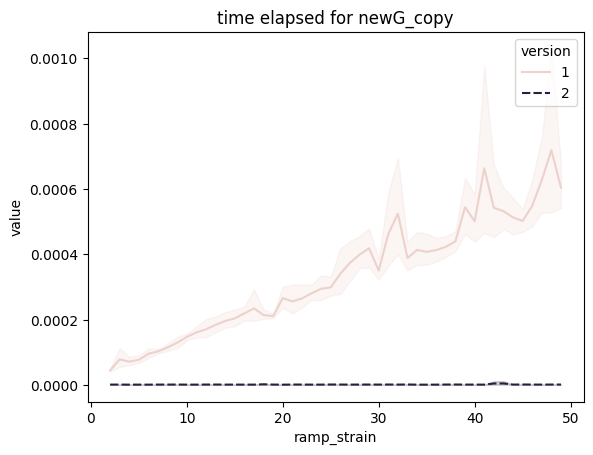

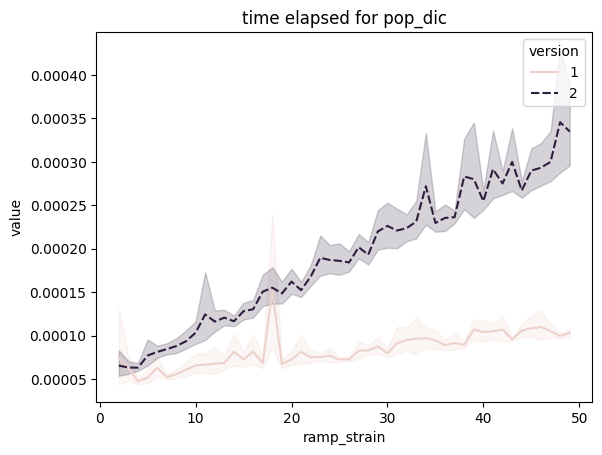

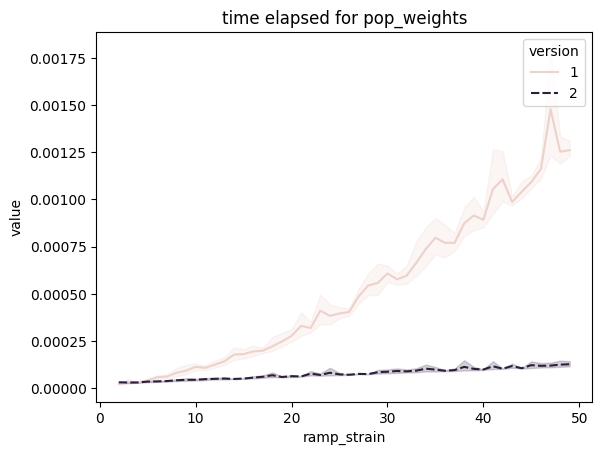

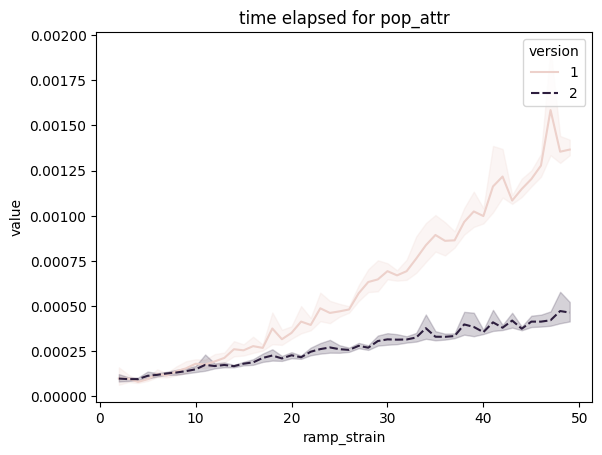

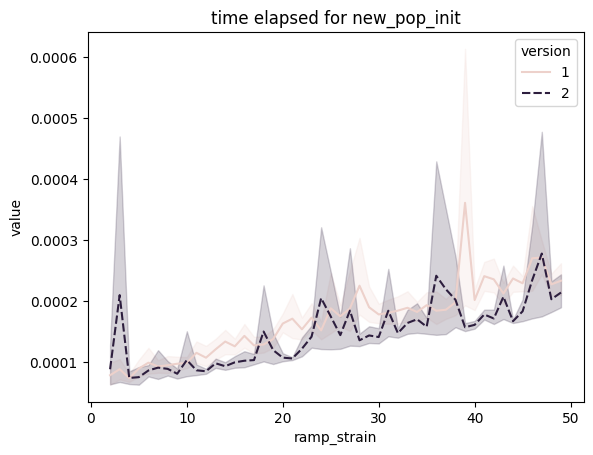

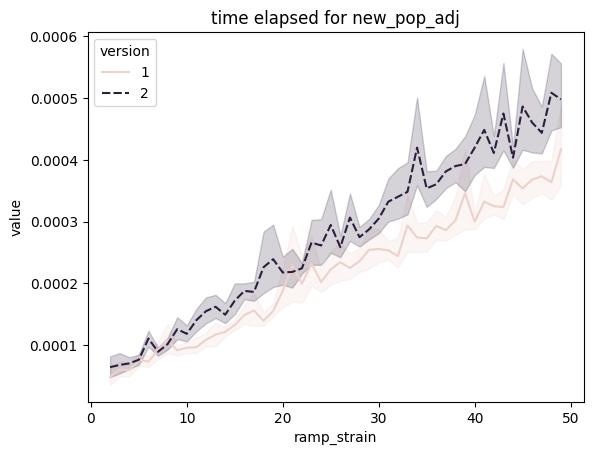

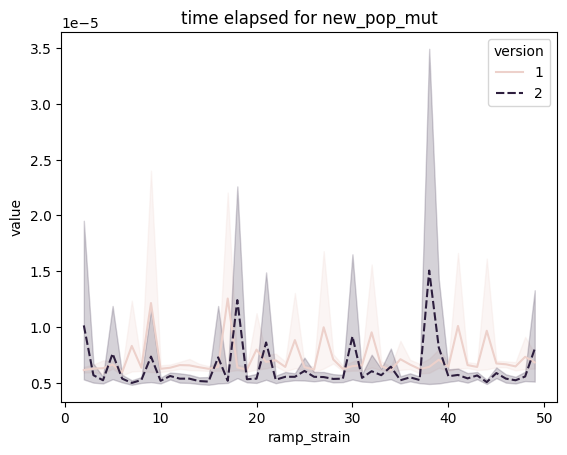

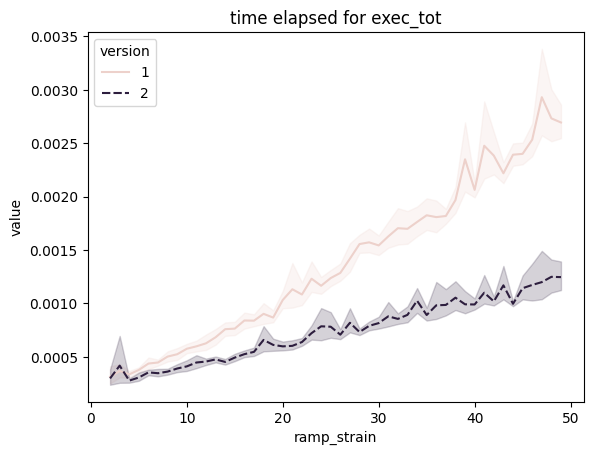

In [17]:
from project_package.run_model import update_pop2_with_tracers


from project_package.generate_pop import generate_random_initial_pop_unlinked

df=pd.DataFrame([],columns=['version','trial','mem_needed','mutation_rate','pop_size','richness','mean_fitness','Fst'])
time_df=pd.DataFrame([],columns=['version','trial','ramp_strain','time_chunk','value'])

mutation_rate=0 # 10-12
growth_factor=1
n=1000000000
verbose=False



trials=10
versions=[1,2]
ramp_strain=range(2,50)

with alive_bar(trials*len(versions)*len(ramp_strain),force_tty=True) as bar:
    for trial in range(trials):
        np.random.seed(trial+1)

        for strain_count in ramp_strain:
    
            POP=generate_random_initial_pop_unlinked(n=n,i=strain_count)

            for version in versions: # number of trials
                G=POP.copy()

                tracemalloc.start()
                start_time = time.time()
    
                if version==1:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                elif version==2:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop2_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                tot_exec_time=time.time() - start_time
    
                time_df=pd.concat([time_df,
                       pd.DataFrame({'version':[version]*8,
                                     'trial':[trial]*8,
                          'ramp_strain':[strain_count]*8,
                          'time_chunk':['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot'],
                          'value':[time_newG_copy, time_pop_dic,time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut,tot_exec_time]
                         })])
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                
                SP=SymPop(G_plus1)
                
                df.loc[-1] = [version,trial,mem_needed,mutation_rate,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
        

for var in ['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(data=time_df[(time_df.time_chunk==var)],x='ramp_strain',y='value',hue='version',style='version').set(title='time elapsed for '+var)


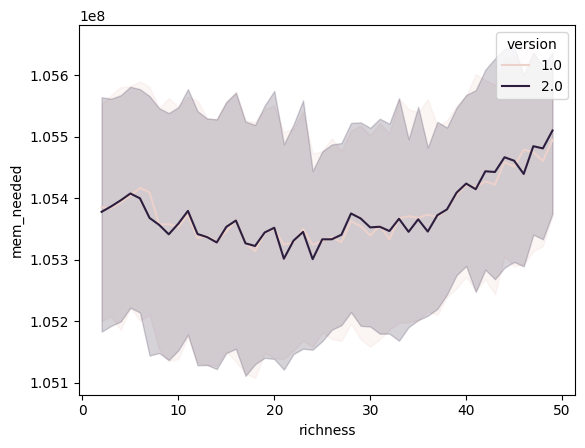

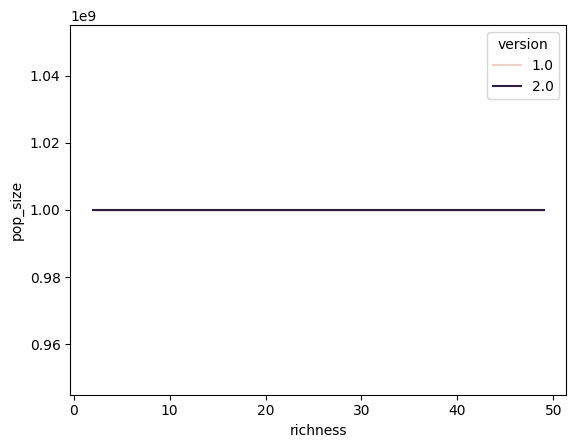

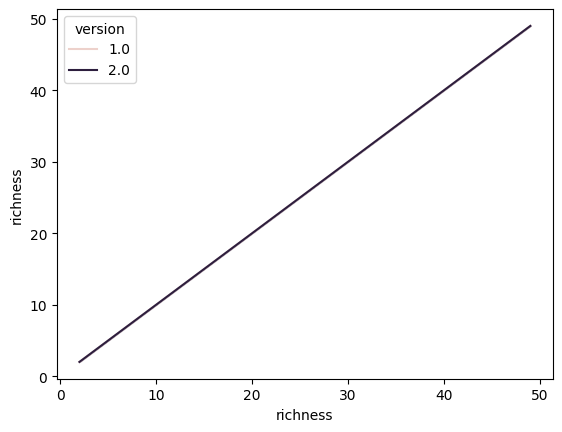

In [18]:
for var in ['mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="richness", y=var, hue='version',
                 data=df[df.richness<50])

# Growing both population and increasing mutation rate

### 10-9

In [35]:
# np.random.seed(666)

df=pd.DataFrame([],columns=['trial','exec_time','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst','heterogeneity'])

mutation_rate=0.000000001
growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
verbose=False

trials=20
runtime=200

POP=generate_initial_pop_unlinked(fitnesses,abundances)

with alive_bar(trials*runtime,force_tty=True) as bar:
    
    for trial in range(trials): # number of trials
        print(trial)
        G=POP.copy()
        t=0
        
    
        while True:
            t+=1
            
            tracemalloc.start()
            start_time = time.time()
    
            G_plus1=update_pop(G,mutation_rate,growth_factor=growth_factor)
            # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
            
            mem_needed=sum(tracemalloc.get_traced_memory())
            exec_time=time.time() - start_time
            
            SP=SymPop(G_plus1)
            G=SP.G
            
            df.loc[-1] = [trial,exec_time,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst,SP.heterogeneity]  # adding a row
            df.index = df.index + 1  # shifting index
            
            bar() 
            
            # if verbose>0:
            #     if t%verbose==0:
            #         print(t)
            
            if t>runtime:
                break   
    
df[-4:]

on 0: 0                                                                         
on 201: 1                                                                       
on 402: 2                                                                       
on 603: 3                                                                       
on 804: 4                                                                       
on 1005: 5                                                                      
on 1206: 6                                                                      
on 1407: 7                                                                      
on 1608: 8                                                                      
on 1809: 9                                                                      
on 2010: 10                                                                     
on 2211: 11                                                                     
on 2412: 12                 

trial  exec_time   mem_needed  mutation_rate    gen   pop_size  richness  \
3   19.0   0.000201  182027181.0   1.000000e-09  198.0  1427597.0       2.0   
2   19.0   0.000231  182028659.0   1.000000e-09  199.0  1498976.0       2.0   
1   19.0   0.000283  182031883.0   1.000000e-09  200.0  1573924.0       2.0   
0   19.0   0.000210  182035107.0   1.000000e-09  201.0  1652620.0       2.0   

   mean_fitness       Fst  heterogeneity  
3         0.925  0.000003            0.0  
2         0.925  0.000003            0.0  
1         0.925  0.000006            0.0  
0         0.925  0.000007            0.0

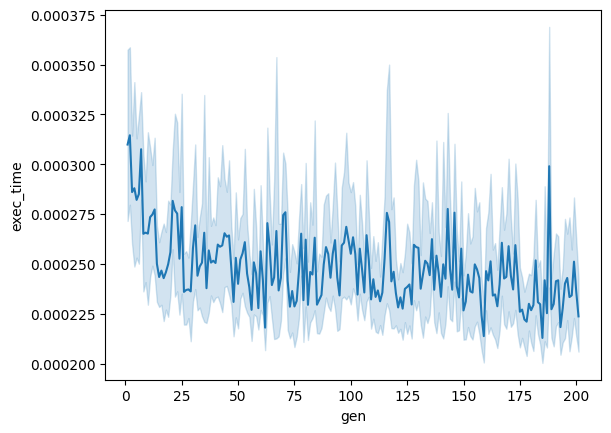

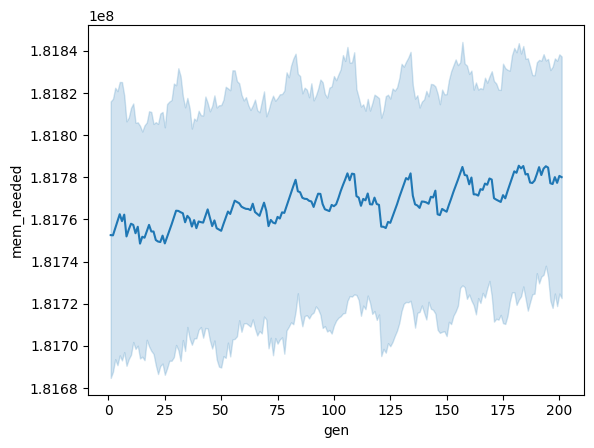

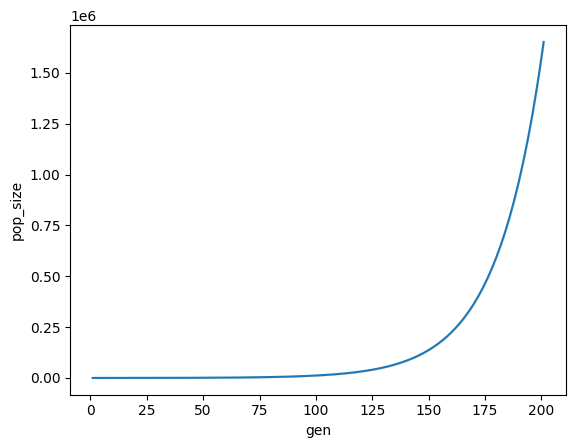

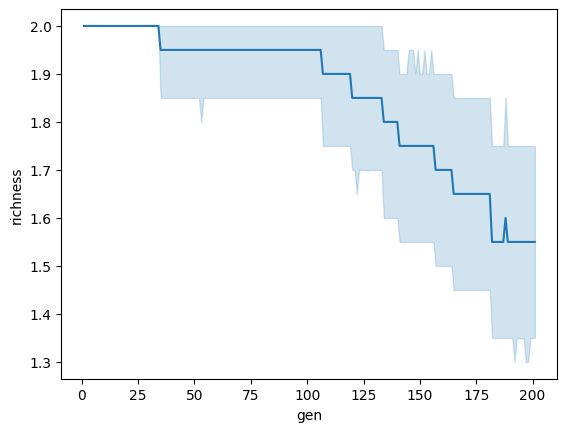

In [38]:
import seaborn as sns

for var in ['exec_time','mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var,
                 data=df)


### 10-7

In [49]:
# np.random.seed(666)

df=pd.DataFrame([],columns=['trial','exec_time','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst','heterogeneity'])

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
verbose=False

trials=20
runtime=200
mutation_rates=[0.0000001]
POP=generate_initial_pop_unlinked(fitnesses,abundances)

for mutation_rate in mutation_rates:
    print(mutation_rate)
    with alive_bar(trials*runtime,force_tty=True) as bar:
        
        for trial in range(trials): # number of trials
            G=POP.copy()
            t=0
            
        
            while True:
                t+=1
                
                tracemalloc.start()
                start_time = time.time()
        
                G_plus1=update_pop(G,mutation_rate,growth_factor=growth_factor)
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                exec_time=time.time() - start_time
                
                SP=SymPop(G_plus1)
                G=SP.G
                
                df.loc[-1] = [trial,exec_time,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst,SP.heterogeneity]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
                
                # if verbose>0:
                #     if t%verbose==0:
                #         print(t)
                
                if t>runtime:
                    break   
    
df[-4:]

1e-07
|████████████████████████████████████████✗︎ (!) 4020/4000 [100%] in 12.8s (313.52


trial  exec_time   mem_needed  mutation_rate    gen   pop_size  richness  \
3   19.0   0.000264  586486301.0   1.000000e-07  198.0  1427597.0       2.0   
2   19.0   0.000274  586491093.0   1.000000e-07  199.0  1498976.0       2.0   
1   19.0   0.000238  586342333.0   1.000000e-07  200.0  1573924.0       2.0   
0   19.0   0.000274  586346933.0   1.000000e-07  201.0  1652620.0       2.0   

   mean_fitness       Fst  heterogeneity  
3         0.925  0.000641            1.0  
2         0.925  0.000648            1.0  
1         0.925  0.000615            1.0  
0         0.925  0.000611            1.0

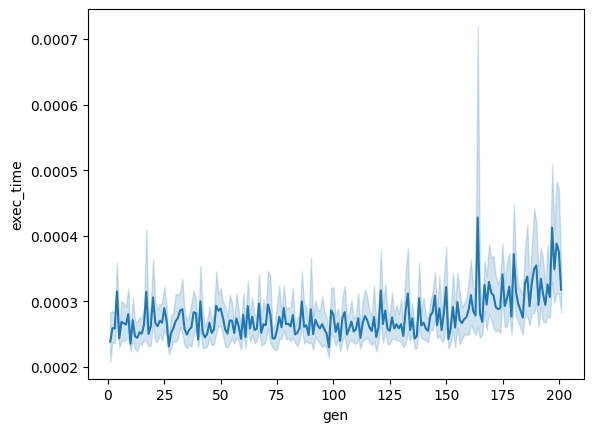

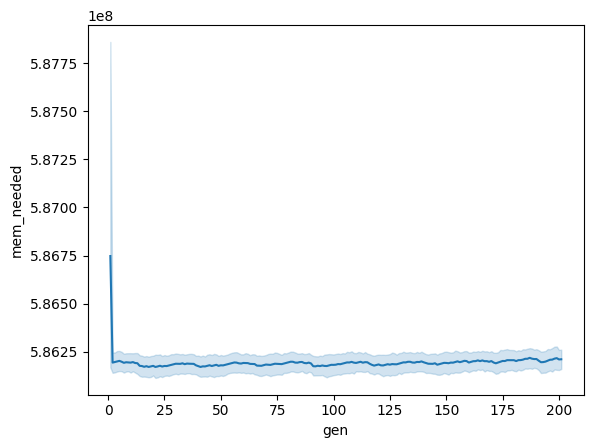

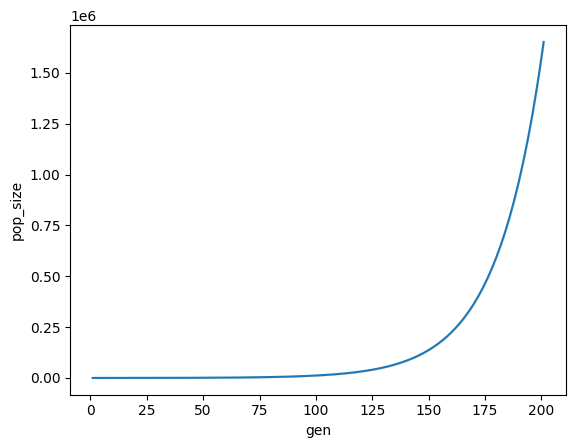

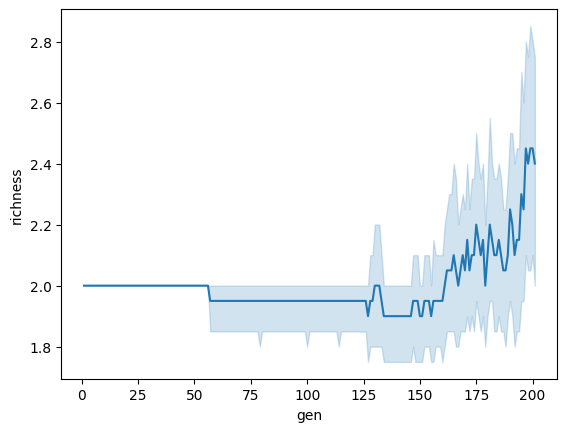

In [51]:
import seaborn as sns

for var in ['exec_time','mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var,
                 data=df)

### 10-6

In [62]:
# np.random.seed(666)

df=pd.DataFrame([],columns=['trial','exec_time','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst'])

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
verbose=False

trials=20
runtime=200
mutation_rates=[0.000001]
POP=generate_initial_pop_unlinked(fitnesses,abundances)

for mutation_rate in mutation_rates:
    print(mutation_rate)
    with alive_bar(trials*runtime,force_tty=True) as bar:
        
        for trial in range(trials): # number of trials
            G=POP.copy()
            t=0
            
        
            while True:
                t+=1
                
                tracemalloc.start()
                start_time = time.time()
        
                G_plus1=update_pop(G,mutation_rate,growth_factor=growth_factor)
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                exec_time=time.time() - start_time
                
                SP=SymPop(G_plus1)
                G=SP.G
                
                df.loc[-1] = [trial,exec_time,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
                
                # if verbose>0:
                #     if t%verbose==0:
                #         print(t)
                
                if t>runtime:
                    break   
    
df[-4:]

1e-06
|████████████████████████████████████████✗︎ (!) 4020/4000 [100%] in 13.5s (298.86


trial  exec_time   mem_needed  mutation_rate    gen   pop_size  richness  \
3   19.0   0.001361  419299990.0       0.000001  198.0  1427597.0       9.0   
2   19.0   0.001234  419331886.0       0.000001  199.0  1498976.0       9.0   
1   19.0   0.001627  419368950.0       0.000001  200.0  1573924.0      14.0   
0   19.0   0.001768  419411814.0       0.000001  201.0  1652620.0      12.0   

   mean_fitness       Fst  
3      0.941856  0.000046  
2      0.937596  0.000065  
1      0.934965  0.000064  
0      0.935065  0.000057

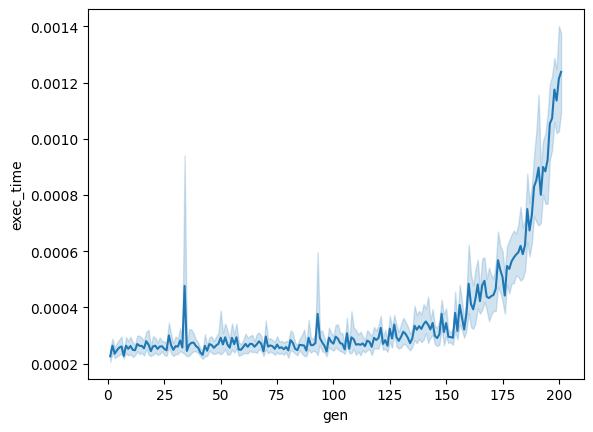

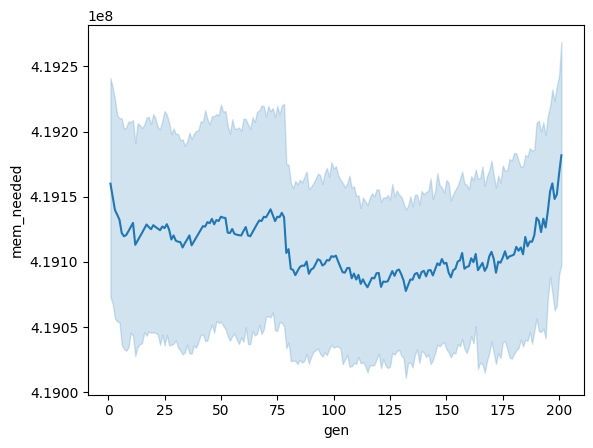

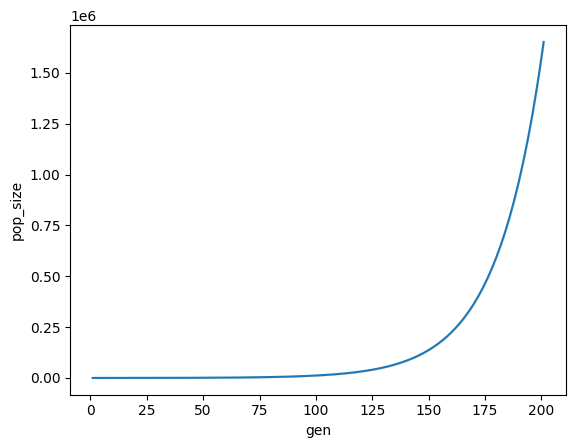

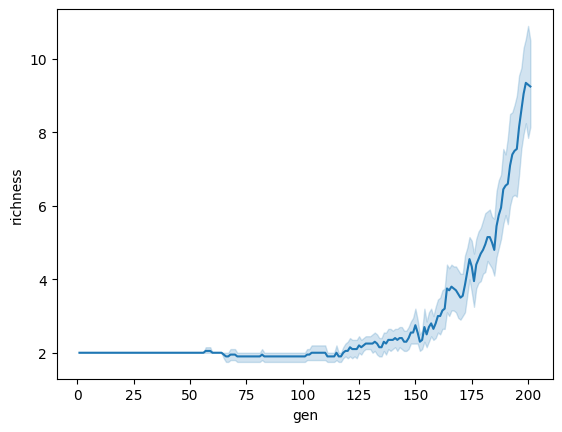

In [63]:
import seaborn as sns

for var in ['exec_time','mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var,
                 data=df)

### 10-5

In [52]:
# np.random.seed(666)

df=pd.DataFrame([],columns=['trial','exec_time','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst','heterogeneity'])

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
verbose=False

trials=20
runtime=200
mutation_rates=[0.00001]
POP=generate_initial_pop_unlinked(fitnesses,abundances)

for mutation_rate in mutation_rates:
    print(mutation_rate)
    with alive_bar(trials*runtime,force_tty=True) as bar:
        
        for trial in range(trials): # number of trials
            G=POP.copy()
            t=0
            
        
            while True:
                t+=1
                
                tracemalloc.start()
                start_time = time.time()
        
                G_plus1=update_pop(G,mutation_rate,growth_factor=growth_factor)
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                exec_time=time.time() - start_time
                
                SP=SymPop(G_plus1)
                G=SP.G
                
                df.loc[-1] = [trial,exec_time,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst,SP.heterogeneity]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
                
                # if verbose>0:
                #     if t%verbose==0:
                #         print(t)
                
                if t>runtime:
                    break   
    
df[-4:]

1e-05
|████████████████████████████████████████✗︎ (!) 4020/4000 [100%] in 29.9s (135.21


trial  exec_time   mem_needed  mutation_rate    gen   pop_size  richness  \
3   19.0   0.011209  413131399.0        0.00001  198.0  1427597.0      69.0   
2   19.0   0.012655  413521407.0        0.00001  199.0  1498976.0      77.0   
1   19.0   0.016547  412689011.0        0.00001  200.0  1573924.0      85.0   
0   19.0   0.019015  413113045.0        0.00001  201.0  1652620.0      81.0   

   mean_fitness       Fst  heterogeneity  
3      0.939242  0.001211          271.0  
2      0.939649  0.001206          283.0  
1      0.940334  0.001222          302.0  
0      0.940461  0.001242          310.0

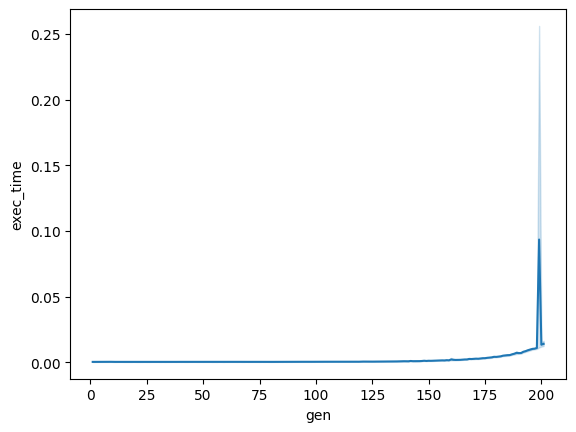

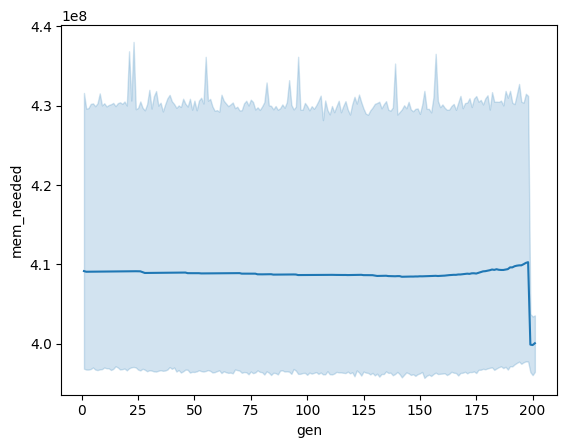

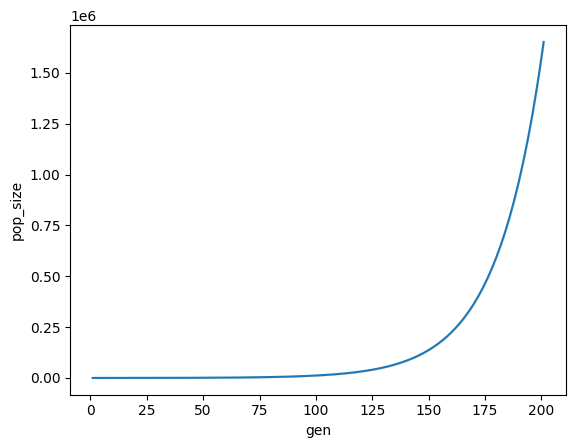

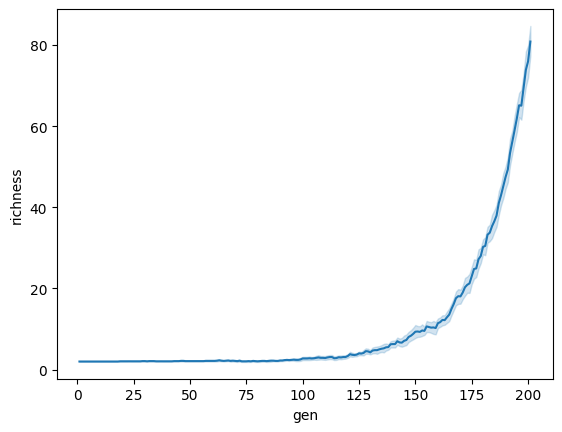

In [53]:
import seaborn as sns

for var in ['exec_time','mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var,
                 data=df)

### 10-4

In [ ]:
# np.random.seed(666)

df=pd.DataFrame([],columns=['trial','exec_time','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst'])

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
verbose=False

trials=20
runtime=200
mutation_rates=[0.0001]
POP=generate_initial_pop_unlinked(fitnesses,abundances)

for mutation_rate in mutation_rates:
    print(mutation_rate)
    with alive_bar(trials*runtime,force_tty=True) as bar:
        
        for trial in range(trials): # number of trials
            G=POP.copy()
            t=0
            
        
            while True:
                t+=1
                
                tracemalloc.start()
                start_time = time.time()
        
                G_plus1=update_pop(G,mutation_rate,growth_factor=growth_factor)
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                exec_time=time.time() - start_time
                
                SP=SymPop(G_plus1)
                G=SP.G
                
                df.loc[-1] = [trial,exec_time,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
                
                # if verbose>0:
                #     if t%verbose==0:
                #         print(t)
                
                if t>runtime:
                    break   
    
df[-4:]

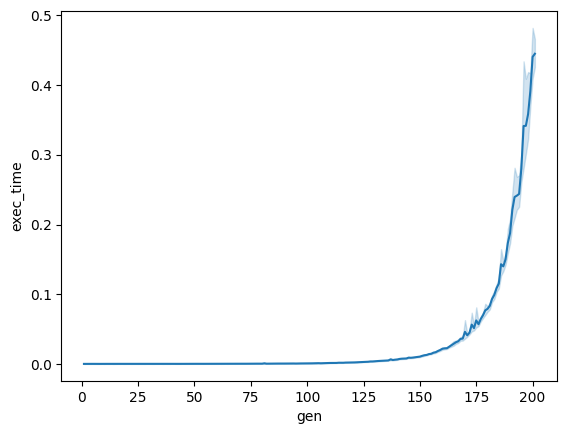

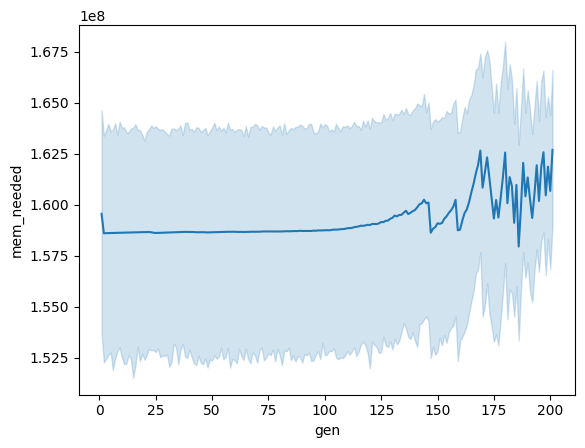

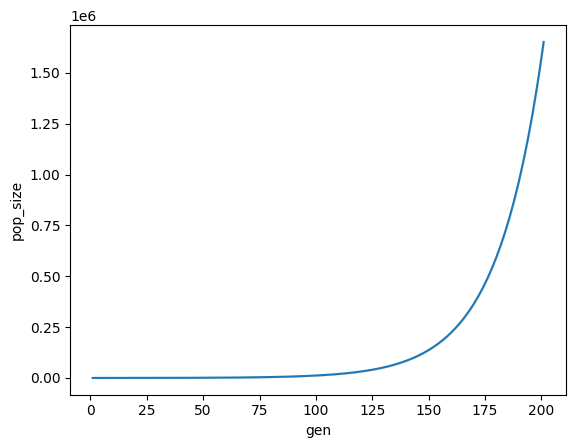

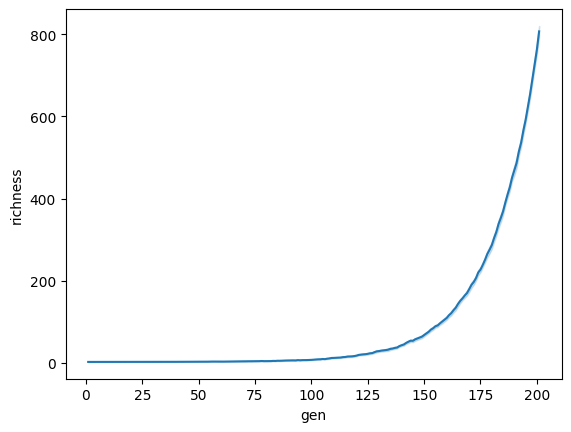

In [26]:
import seaborn as sns

for var in ['exec_time','mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var, hue='trial'
                 data=df)



In [ ]:
sns.lineplot(x="richness", y='mem_needed',
                 hue="trial", 
                 data=df)

In [ ]:
# import seaborn as sns

# df_diversity=df[['gen','mutation_rate','exec_time','mem_needed','pop_size','richness']].melt(id_vars=['gen','mutation_rate'])

# g = sns.FacetGrid(df_diversity, col="variable", hue='mutation_rate',sharex=True, sharey=False)
# g.map_dataframe(sns.lineplot, x="gen",y='value')



### 10-3 

In [64]:
# np.random.seed(666)

df=pd.DataFrame([],columns=['trial','exec_time','mem_needed','mutation_rate','gen','pop_size','richness','mean_fitness','Fst'])

mutation_rate=0.001
growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
verbose=False

trials=20
runtime=150

POP=generate_initial_pop_unlinked(fitnesses,abundances)

with alive_bar(trials*runtime,force_tty=True) as bar:
    
    for trial in range(trials): # number of trials
        print(trial)
        G=POP.copy()
        t=0
        
    
        while True:
            t+=1
            
            tracemalloc.start()
            start_time = time.time()
    
            G_plus1=update_pop(G,mutation_rate,growth_factor=growth_factor)
            # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
            
            mem_needed=sum(tracemalloc.get_traced_memory())
            exec_time=time.time() - start_time
            
            SP=SymPop(G_plus1)
            G=SP.G
            
            df.loc[-1] = [trial,exec_time,mem_needed,mutation_rate,t,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
            df.index = df.index + 1  # shifting index
            
            bar() 
            
            # if verbose>0:
            #     if t%verbose==0:
            #         print(t)
            
            if t>runtime:
                break   
    
df[:4]

on 0: 0                                                                         
on 151: 1                                                                       
on 302: 2                                                                       
on 453: 3                                                                       
on 604: 4                                                                       
on 755: 5                                                                       
on 906: 6                                                                       
on 1057: 7                                                                      
on 1208: 8                                                                      
on 1359: 9                                                                      
on 1510: 10                                                                     
on 1661: 11                                                                     
on 1812: 12                 

trial  exec_time   mem_needed  mutation_rate  gen  pop_size  richness  \
3019    0.0   0.000738  423225759.0          0.001  1.0     105.0       2.0   
3018    0.0   0.000489  423218543.0          0.001  2.0     110.0       2.0   
3017    0.0   0.000328  423220764.0          0.001  3.0     115.0       2.0   
3016    0.0   0.000366  423224572.0          0.001  4.0     120.0       2.0   

      mean_fitness       Fst  
3019         0.925  0.416145  
3018         0.925  0.388264  
3017         0.925  0.349943  
3016         0.925  0.391111

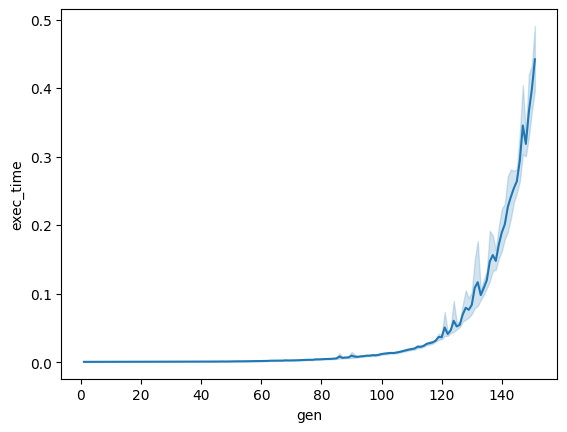

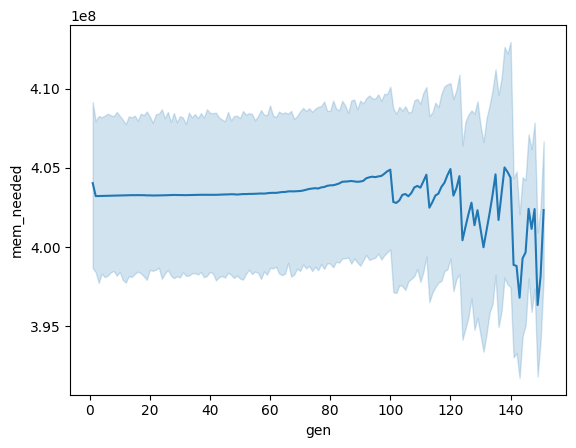

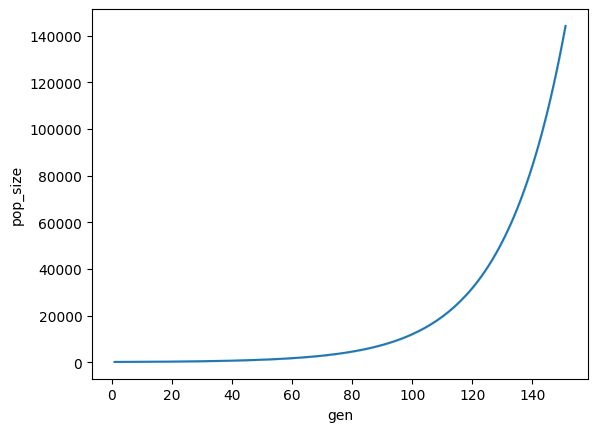

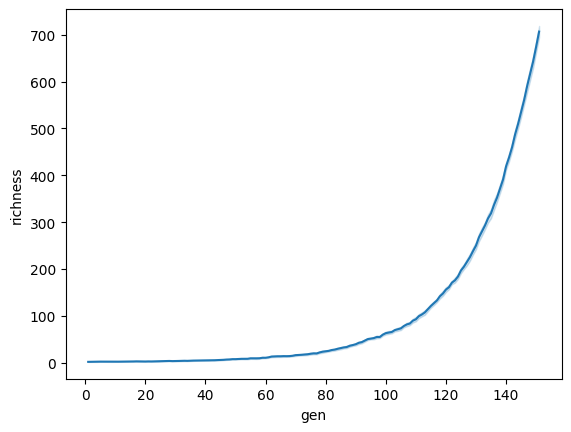

In [65]:
import seaborn as sns

for var in ['exec_time','mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var, 
                 data=df)


## V1 vs V2

### 10-9 

In [ ]:
from project_package.run_model import update_pop2_with_tracers
from project_package.generate_pop import generate_random_initial_pop_unlinked

df=pd.DataFrame([],columns=['version','trial','gen','mem_needed','mutation_rate','pop_size','richness','mean_fitness','Fst'])
time_df=pd.DataFrame([],columns=['version','trial','gen','time_chunk','value'])



mutation_rate=0.000000001# 10-9
# mutation_rate=0 
# growth_factor=1.05
# fitnesses=[0.9]*20 # allele_id:fitness
# abundances=[500000]*20 # allele_id:abundance

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[300000000,700000000] # allele_id:abundance
n=sum(abundances)

trials=10
runtime=50
versions=[1,2]

with alive_bar(len(versions)*trials*runtime,force_tty=True) as bar:
    
    for trial in range(trials): # number of trials
        np.random.seed(trial+10)
        POP=generate_initial_pop_unlinked(fitnesses,abundances)

        
        for version in versions: # number of trials
            G=POP.copy()
            gen=0
    
            while True:
                gen+=1
                tracemalloc.start()
                start_time = time.time()
    
                if version==1:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                elif version==2:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop2_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                tot_exec_time=time.time() - start_time
    
                time_df=pd.concat([time_df,
                       pd.DataFrame({'version':[version]*8,
                                     'trial':[trial]*8,
                          'gen':[gen]*8,
                          'time_chunk':['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot'],
                          'value':[time_newG_copy, time_pop_dic,time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut,tot_exec_time]
                         })])
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                
                SP=SymPop(G_plus1)
                G=SP.G
                
                df.loc[-1] = [version,trial,gen,mem_needed,mutation_rate,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
        
                if gen>runtime:
                    break 


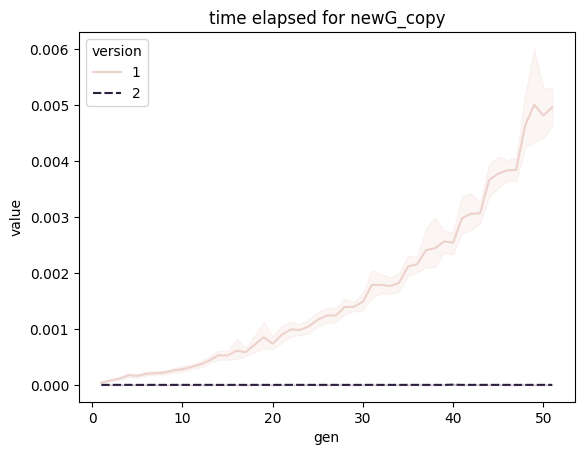

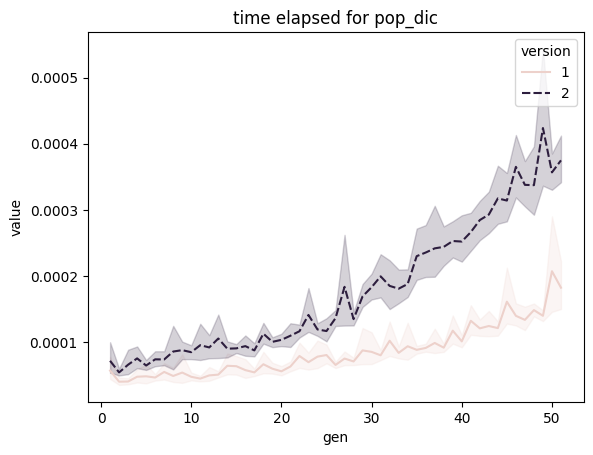

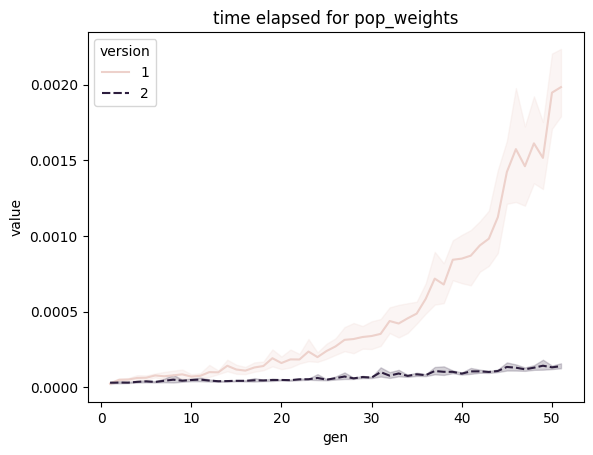

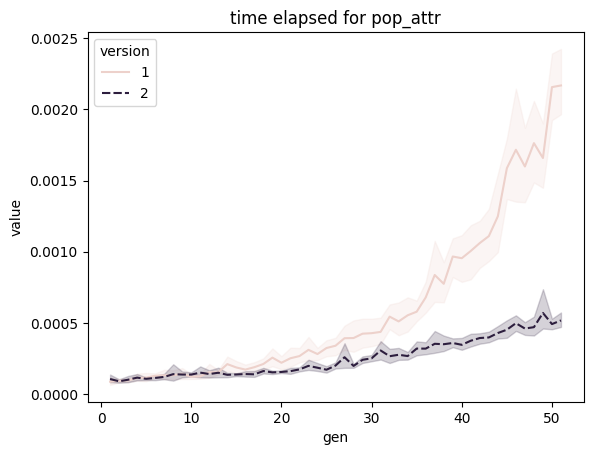

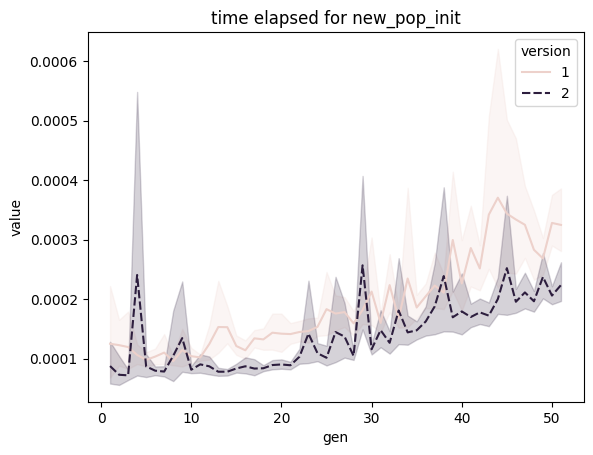

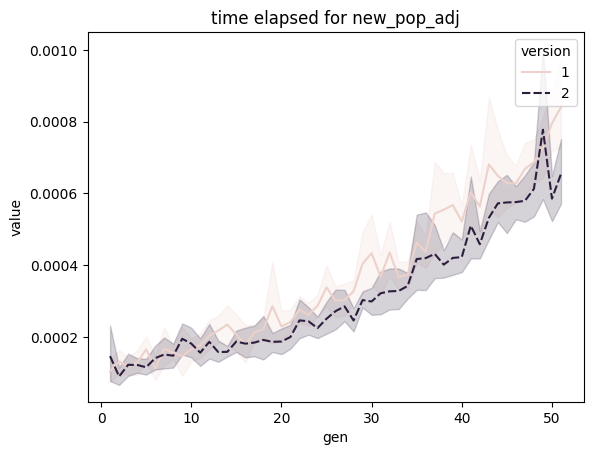

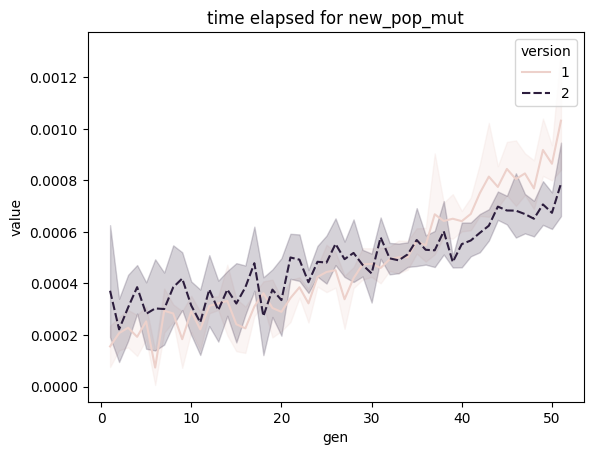

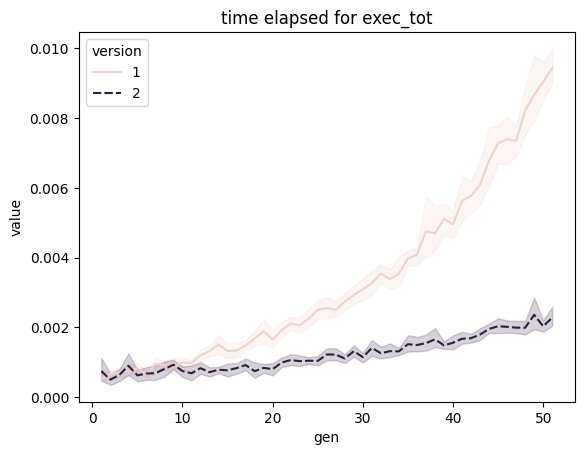

In [34]:
for var in ['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(data=time_df[(time_df.time_chunk==var) ],x='gen',y='value',hue='version',style='version').set(title='time elapsed for '+var)


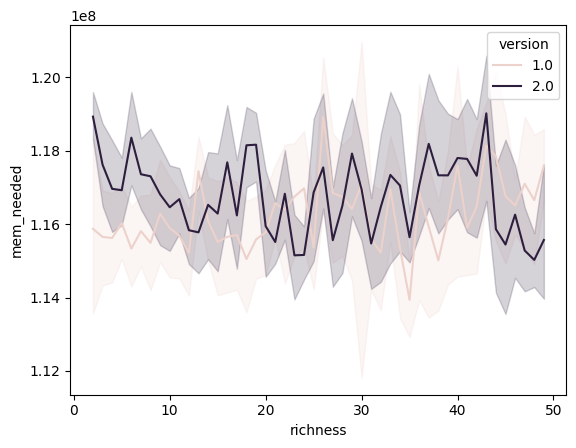

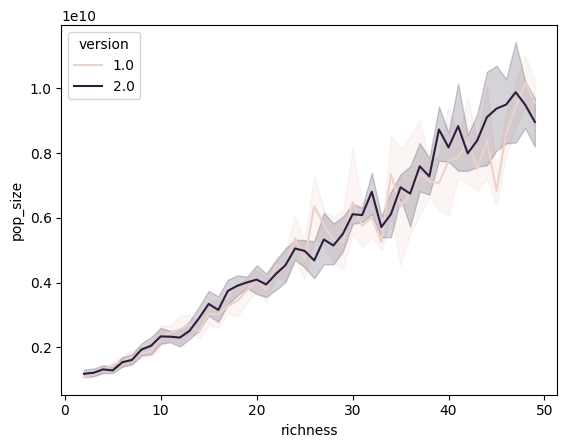

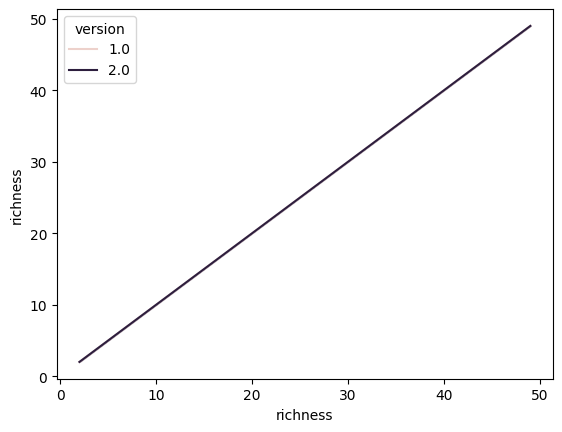

In [35]:
for var in ['mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="richness", y=var, hue='version',
                 data=df[df.richness<50])

### 10-4

In [39]:
from project_package.run_model import update_pop2_with_tracers
from project_package.generate_pop import generate_random_initial_pop_unlinked

df=pd.DataFrame([],columns=['version','trial','gen','mem_needed','mutation_rate','pop_size','richness','mean_fitness','Fst'])
time_df=pd.DataFrame([],columns=['version','trial','gen','time_chunk','value'])



mutation_rate=0.0001# 10-4
# mutation_rate=0 
# growth_factor=1.05
# fitnesses=[0.9]*20 # allele_id:fitness
# abundances=[500000]*20 # allele_id:abundance

growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
n=sum(abundances)

trials=20
runtime=150
versions=[1,2]

with alive_bar(len(versions)*trials*runtime,force_tty=True) as bar:
    
    for trial in range(trials): # number of trials
        np.random.seed(trial+10)
        POP=generate_initial_pop_unlinked(fitnesses,abundances)

        
        for version in versions: # number of trials
            G=POP.copy()
            gen=0
    
            while True:
                gen+=1
                tracemalloc.start()
                start_time = time.time()
    
                if version==1:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                elif version==2:
                    G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop2_with_tracers(G,mutation_rate,growth_factor=growth_factor)
                
                # G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)
                tot_exec_time=time.time() - start_time
    
                time_df=pd.concat([time_df,
                       pd.DataFrame({'version':[version]*8,
                                     'trial':[trial]*8,
                          'gen':[gen]*8,
                          'time_chunk':['newG_copy', 'pop_dic','pop_weights','pop_attr','new_pop_init', 'new_pop_adj', 'new_pop_mut', 'exec_tot'],
                          'value':[time_newG_copy, time_pop_dic,time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut,tot_exec_time]
                         })])
                
                mem_needed=sum(tracemalloc.get_traced_memory())
                
                SP=SymPop(G_plus1)
                G=SP.G
                
                df.loc[-1] = [version,trial,gen,mem_needed,mutation_rate,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
                df.index = df.index + 1  # shifting index
                
                bar() 
        
                if gen>runtime:
                    break 


on 0: /var/folders/4k/fyxyxd_96gsc6cfglggb83tr0000gn/T/ipykernel_17749/3875616939.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
        time_df=pd.concat([time_df,


|████████████████████████████████████████✗︎ (!) 6040/6000 [101%] in 1:16.4 (79.22▃▅▇ 2842/6000 [47%] in 30s (~33s, 94. ▆█▆ 3458/6000 [58%] in 37s (~27s, 93. ▄▂▂ 4982/6000 [83%] in 1:03 (~12s, 84


[Text(0.5, 1.0, 'time elapsed for each gen')]

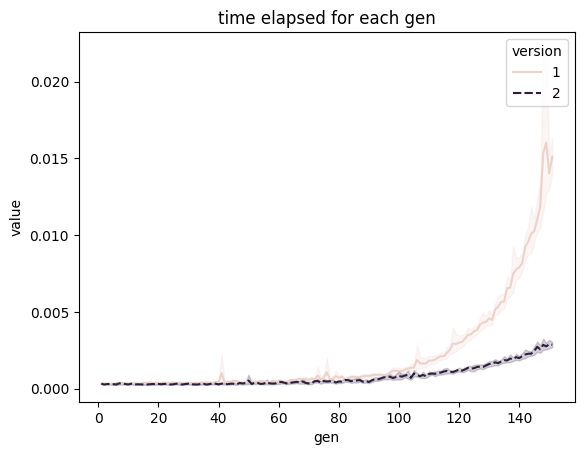

In [44]:
plt.figure()
# Plot the responses for different events and regions
sns.lineplot(data=time_df[(time_df.time_chunk=='exec_tot') ],x='gen',y='value',hue='version',style='version').set(title='time elapsed for each gen')


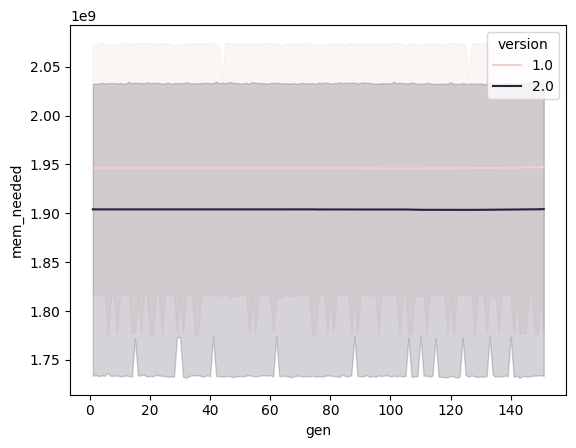

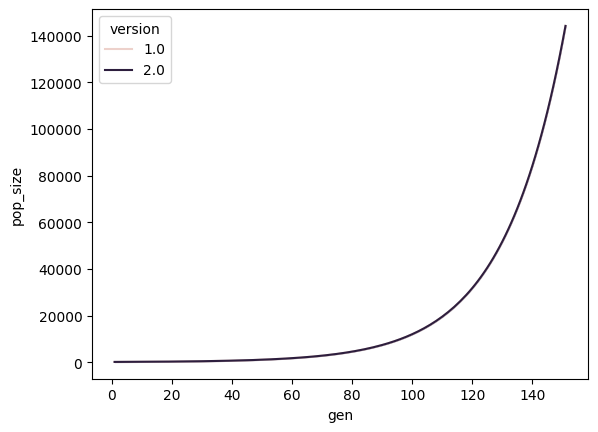

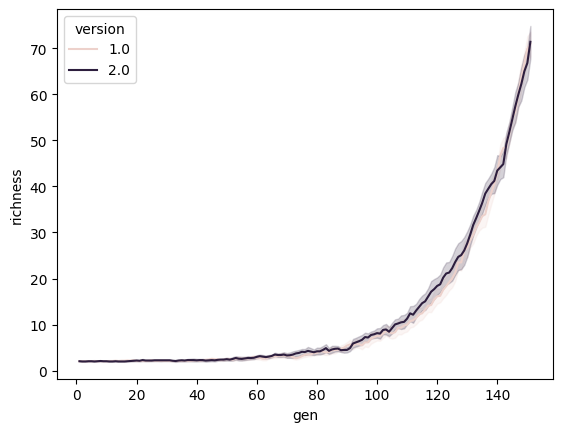

In [43]:

for var in ['mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var, hue='version',
                 data=df)

## V2 Adult model

In [51]:
from project_package.run_model import update_pop2_with_tracers
from project_package.generate_pop import generate_random_initial_pop_unlinked
from project_package.simplify import remove_empty_leaves_and_rescale_edges

df=pd.DataFrame([],columns=['version','trial','gen','tot_exec_time','mem_needed','mutation_rate','pop_size','richness','mean_fitness','Fst'])

mutation_rate=0.00000001# 10-8 bact mutation rate
fitnesses=[0.8]*20 # allele_id:fitness
abundances=[500000000]*20 # allele_id:abundance

growth_factor=1
n=sum(abundances)
print(n)
trials=20
runtime=500

with alive_bar(trials*runtime,force_tty=True) as bar:
    POP=generate_initial_pop_unlinked(fitnesses,abundances)

    for trial in range(trials): # number of trials
        np.random.seed(trial+10)
        G=POP.copy()

        gen=0

        while True:
            gen+=1
            tracemalloc.start()
            start_time = time.time()

            G_plus1,time_newG_copy, time_pop_dic, time_pop_weights, time_pop_attr, time_new_pop_init, time_new_pop_adj, time_new_pop_mut=update_pop2_with_tracers(G,mutation_rate,growth_factor=growth_factor)
            
            tot_exec_time=time.time() - start_time
            G_plus1=remove_empty_leaves_and_rescale_edges(G_plus1)

            SP=SymPop(G_plus1)
            G=SP.G
            
            df.loc[-1] = [version,trial,gen,tot_exec_time,mem_needed,mutation_rate,SP.pop_size,SP.richness,SP.mean_fitness,SP.Fst]  # adding a row
            df.index = df.index + 1  # shifting index
            
            bar() 
    
            if gen>runtime:
                break 


10000000000
|████████████████████████████████████████✗︎ (!) 10020/10000 [100%] in 22:06.5 (7.▇▇▅ 116/10000 [1%] in 12s (~16:03, 10 █▆▄ 415/10000 [4%] in 1:03 (~23:59, 6 ▂▂▄ 476/10000 [5%] in 1:13 (~24:24, 6 ▅▇▇ 1805/10000 [18%] in 4:21 (~19:46, ▄▂▂ 3688/10000 [37%] in 8:20 (~14:16, ▅▇▇ 4057/10000 [41%] in 9:07 (~13:21, ▆█▆ 5084/10000 [51%] in 11:15 (~10:53 ▁▃▅ 7243/10000 [72%] in 15:41 (~5:58, ▆█▆ 8141/10000 [81%] in 17:41 (~4:02, ▆█▆ 8495/10000 [85%] in 18:35 (~3:18, ▄▂▂ 9169/10000 [92%] in 20:06 (~1:49, ▄▂▂ 9400/10000 [94%] in 20:38 (~1:19, ▃▁▃ 9886/10000 [99%] in 21:48 (~15s, 


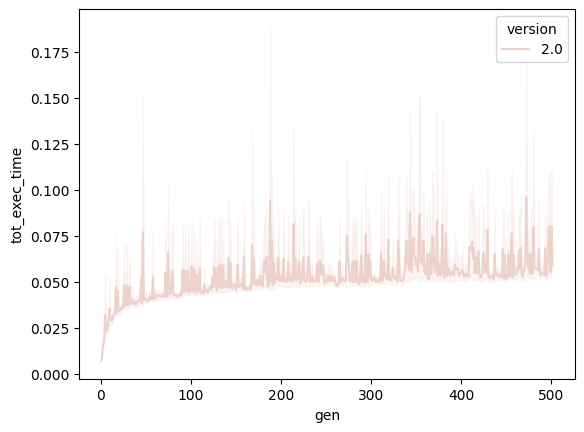

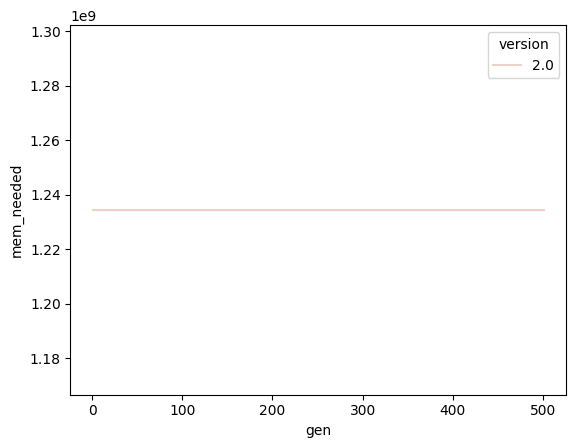

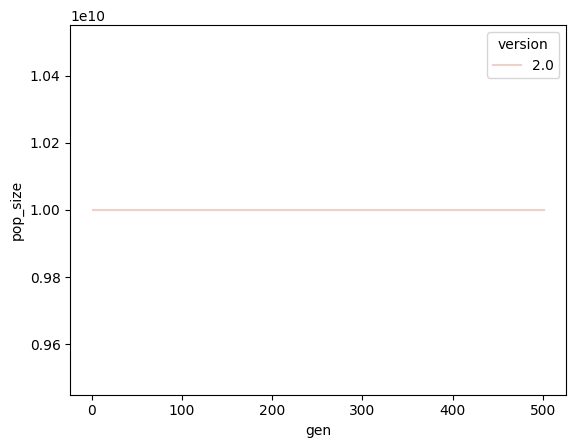

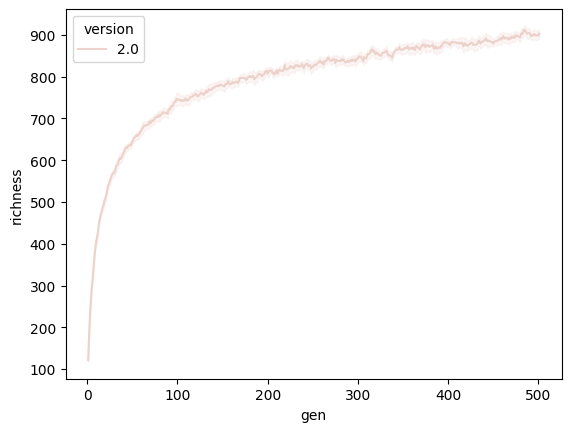

In [53]:

for var in ['tot_exec_time','mem_needed','pop_size','richness']:
    
    plt.figure()
    # Plot the responses for different events and regions
    sns.lineplot(x="gen", y=var, hue='version',
                 data=df)

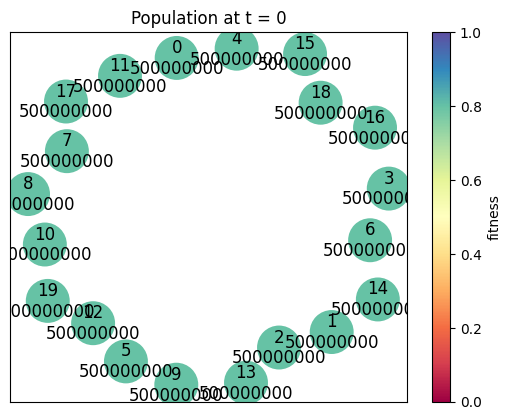

In [70]:
visualize_pop(SymPop(POP).G)

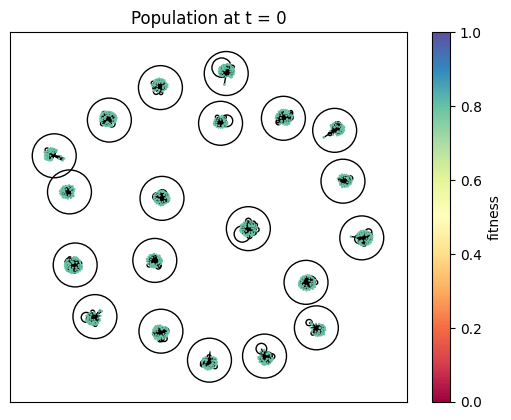

In [75]:
# %load_ext autoreload
# %autoreload 2
from project_package.plot import visualize_pop

visualize_pop(G,view_node_labels=False,view_edge_labels=False,transparency_threshold=100)